# Predict Daily Bike  Rental  Ridership
by NK Zhehua Zou

---

### Table of contents

1- Dataset Characteristics  
2- Preprocess Data  
3- Modeling  
4- Implement  
5- Unit Test

---

### 1- Dataset Characteristics
	
*** Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv ***  
- instant: record index  
- dteday : date  
- season : season (1:springer, 2:summer, 3:fall, 4:winter)  
- yr : year (0: 2011, 1:2012)  
- mnth : month ( 1 to 12)  
- hr : hour (0 to 23)  
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)  
- weekday : day of the week  
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.  
- weathersit :   
  1: Clear, Few clouds, Partly cloudy, Partly cloudy  
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)  
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)  
- hum: Normalized humidity. The values are divided to 100 (max)  
- windspeed: Normalized wind speed. The values are divided to 67 (max)   
- casual: count of casual users  
- registered: count of registered users  
- cnt: count of total rental bikes including both casual and registered  

### 2- Preprocess Data

In [1]:
# load dataset
import pandas as pd

rides = pd.read_csv('Bike-Sharing-Dataset/hour.csv')

In [2]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# find the missing values
rides.isnull().sum().sort_values(ascending=False)[:5]

cnt        0
weekday    0
dteday     0
season     0
yr         0
dtype: int64

In [4]:
# summary & find the outlier
rides.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


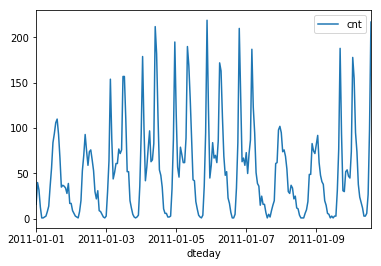

In [5]:
%matplotlib inline

# the number of bike riders over the first 10 days  24 hours
rides[:10*24].plot(x='dteday', y='cnt')

In [6]:
# dummy a set of variables from selected variables. such as season(1,2,3,4) to season_1, season_2, season_3, season_4
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# drop unuseful variables
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

In [7]:
# debug, check the header of dataset
#list(data)

In [8]:
# standardize each of the continuous variables to make training the network easier
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [9]:
# cut the last 21 days * 24 hours as test set
test_data = data[-21*24:]
data = data[:-21*24]

In [10]:
# separate the data into features and targets (use labels on classification & targets on prediction)
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [11]:
# split data as train data and validation data (the last 60 days * 24 hours)
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

### 3- Modeling

In [12]:
import numpy as np

'''
backpropagation: use the weights to propagate signals forward from the input to the output layers,
use the weights to also propagate error backwards from the output back into the network to update our weights.
'''

class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # number of nodes in input, hidden and output layers
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, (self.hidden_nodes, self.input_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        # activation function = sigmoid function
        self.activation = self.sigmoid
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # forward pass in hidden layer, signals -(input)-> hidden layer -(output/input)-> final output layer -(output)->
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation(hidden_inputs)
        final_outputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        
        # backward pass,output error is the difference between desired target and actual output
        # caculate the backpropagated error & gradients of hidden layer, then update the weights
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)
        hidden_grad = hidden_outputs * (1 - hidden_outputs)
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T)
        self.weights_input_to_hidden += self.lr * np.dot((hidden_errors * hidden_grad), inputs.T)

    # same with the first part of train function, use for predictions after train
    def run(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation(hidden_inputs)
        final_outputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        return final_outputs

In [13]:
# caculate the mean of standard deviation, use for caculate loss
def MSE(y, Y):
    return np.mean((y-Y)**2)

### 4- Implement

In [14]:
import sys

'''
try:
epochs = 2000, learning_rate = 0.01, hidden_nodes = 20, Training loss: 0.064, Validation loss: 0.200
epochs = 5000, learning_rate = 0.01, hidden_nodes = 20, Training loss: 0.050, Validation loss: 0.147
epochs = 8000, learning_rate = 0.01, hidden_nodes = 20, Training loss: 0.044, Validation loss: 0.140 (Best)

epochs = 8000, learning_rate = 0.005, hidden_nodes = 20, Training loss: 0.055, Validation loss: 0.210
epochs = 8000, learning_rate = 0.01, hidden_nodes = 20, Training loss: 0.044, Validation loss: 0.140
epochs = 8000, learning_rate = 0.015, hidden_nodes = 20, Training loss: 0.050, Validation loss: 0.123 (Best)

epochs = 8000, learning_rate = 0.015, hidden_nodes = 20, Training loss: 0.050, Validation loss: 0.123 (Best)
epochs = 8000, learning_rate = 0.015, hidden_nodes = 35, Training loss: 0.045, Validation loss: 0.184
epochs = 8000, learning_rate = 0.015, hidden_nodes = 50, Training loss: 0.055, Validation loss: 0.189
'''

# hyperparameters
epochs = 2000
learning_rate = 0.015
hidden_nodes = 20
output_nodes = 1

# input_nodes = features = columns of dataset
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # random batch of 128 from the train data
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # print progress, only print final progress if add \r at first, print all epoch without \r
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write('\rProgress: ' + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    # store data for plotting the loss in each epoch
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.068 ... Validation loss: 0.150

(-0.020713783594340639, 1)

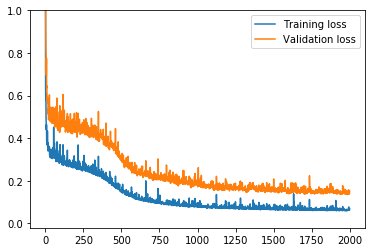

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=1)

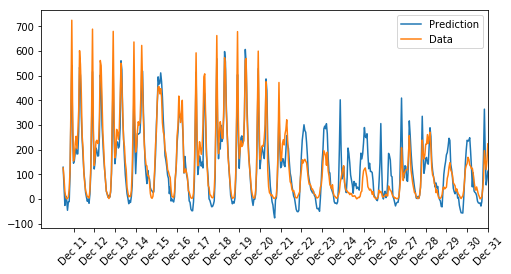

In [16]:
'''
Really interesting in here, predicted well after Dec 22nd while epoch=10,
predicted well before Dec 22nd while epoch=1500 or more.
It is hard to predicts after Dec 22nd because the behavior of the clients is different on holidays.
'''

# caculate the number of rides of predictions
mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean

# plotting
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

# convert date format and set rotation on x-axis
dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

### 5- Unit Test

In [17]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
# test of data loading and format
    def test_data_path(self):
        self.assertTrue('bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
# test network functions
# the activation function is a sigmoid, weights are updated correctly on training, correctness of run method
    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        self.assertTrue(np.all(network.activation(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.016s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>